# **Q1. Visualization**
## **1. Loading datasets**

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install squarify

In [3]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)                  # 모든 컬럼 표시
pd.set_option("display.max_rows", None)                     # 모든 로우 표시
pd.set_option('display.float_format', lambda x: '%.3f' % x) # 읽기 힘든 e+-대신 소수점 3자리까지 표시

In [28]:
import matplotlib.pyplot as plt
import squarify
plt.rc('font', family='NanumBarunGothic') 

In [5]:
df = pd.read_csv("pretest_data.csv")
df_raw = df.copy()

In [4]:
df.head(3)

,video_id,channel_id,published_date,category_name,duration,tags,description,on_trending_date,off_trending_date,on_rank,off_rank,on_views,off_views,on_likes,off_likes,on_dislikes,off_dislikes,on_comments,off_comments,on_channel_subscribers,off_channel_subscribers,on_channel_total_views,off_channel_total_views,on_channel_total_videos,off_channel_total_videos
0,V-0db,CH49ta0,2021-07-01,Entertainment,PT8M20S,SiriusXM|Sirius XM|Sirius|SXM|BIGHIT|빅히트|방탄소년단...,BTS performs their hit songs ‘Dynamite’ and ‘B...,2021-07-03,2021-07-04,13,28,1659484,1912983,270004,282204,792,1014,10373,10720,1080000,1080000,685992413,687485021,5947,5950
1,V-1XL,CHZVD--,2021-06-24,Entertainment,PT9M17S,치킨불냉면|치킨|불냉면|냉면,영상에 나오는 캐릭터의 이름은 파도비 입니다. 고양이가 아니라 파란 도깨비입니다. ...,2021-06-26,2021-06-27,28,45,293559,374698,7121,8165,121,154,1083,1173,627000,628000,75327083,75685030,70,70
2,V-4fa,CH9w-h_,2021-07-17,Entertainment,PT7M39S,NaN,"거세 구형, 성 충동 제거를 위한 엄벌 치료 VS 인권 보호해야고민 끝에 내린 강요...",2021-07-19,2021-07-22,1,23,451260,757265,3994,5684,162,233,696,1006,5750000,5750000,5424167911,5431617741,34270,34341


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   video_id                  2644 non-null   object
 1   channel_id                2644 non-null   object
 2   published_date            2644 non-null   object
 3   category_name             2644 non-null   object
 4   duration                  2644 non-null   object
 5   tags                      2274 non-null   object
 6   description               2604 non-null   object
 7   on_trending_date          2644 non-null   object
 8   off_trending_date         2644 non-null   object
 9   on_rank                   2644 non-null   int64 
 10  off_rank                  2644 non-null   int64 
 11  on_views                  2644 non-null   int64 
 12  off_views                 2644 non-null   int64 
 13  on_likes                  2644 non-null   int64 
 14  off_likes               

## **2. Data cleaning and Derivation of three new features**

* **Drop duplicated record**  : 중복 레코드를 삭제
* **Transformate features**   
  * `date-time` :  모든 시간 관련 피처의 데이터 타입을 str에서 datetime으로 변경 
  * `tags split` : 태그 표지('|') 제거하여 태그를 분할
  * `duration` : 영상 길이를 초 단위로 변환 (PT5S > 5)
* **New feature variable creation**   
  * `trending_duration` : 인기 동영상 진입 기간(일)
  * `published_month`, `published_weekofmonth` : 기준 월, 기준 주 
  * `len_description` : 영상 설명 텍스트의 길이

### Drop duplicated record

In [6]:
# 데이터 내의 'video_id'가 모두 고유한 값을 지니는지 확인한다.

unique_video = list(df['video_id'].unique())

print(f"중복 레코드 개수: {df.shape[0] - len(unique_video)}")
print(f"전체 비디오 개수 = {df.shape[0]}, 고유 비디오 개수 = {len(unique_video)}")

중복 레코드 개수: 1
전체 비디오 개수 = 2644, 고유 비디오 개수 = 2643


In [7]:
# 중복된 'video_id'를 가진 레코드를 검출하기 위해 'video_id' 빈도를 확인한다.

df['freq'] = df['video_id'].value_counts()
df['freq'] = df.groupby('video_id')['video_id'].transform('count')

for index, frequency in enumerate(df['freq']):
  if frequency > 1:
    print(index, frequency)

534 2
535 2


In [8]:
# index 534, 535의 'video_id'는 'VBSBm'으로 같지만 실제로는 다른 비디오임을 알 수 있다.

print(f"- index 534\n{df[['video_id', 'channel_id', 'category_name', 'tags']].loc[534]}\n")
print(f"- index 534\n{df[['video_id', 'channel_id', 'category_name', 'tags']].loc[535]}")

- index 534
video_id                                                     VBSBm
channel_id                                                 CH0VR2v
category_name                                        Entertainment
tags             요리|레시피|육식|고기|육식맨|고기요리|YOOXICMAN|짜장면|자장면|짜장|고기짜...
Name: 534, dtype: object

- index 534
video_id                                                     VBSBm
channel_id                                                 CHF4Wxd
category_name                                      News & Politics
tags             MBC|MBC뉴스|뉴스데스크|newsdesk|뉴스투데이|newstoday|8시뉴스|...
Name: 535, dtype: object


In [9]:
# index 535의 'video_id'를 변경해준다. (기존: VBSBm, 변경 후: VBSBM)

df.loc[535, 'video_id'] = 'VBSBM'
df.loc[534:535, 'video_id']

534    VBSBm
535    VBSBM
Name: video_id, dtype: object

In [10]:
df = df.drop(['freq'], axis=1)  # 사용하지 않는 'freq' 컬럼을 제거한다.

### Transformate features

In [11]:
!pip install isodate

     |████████████████████████████████| 41 kB 611 kB/s 


In [11]:
# 'duration' - 해당 컬럼을 초 단위로 변환

import isodate
df['duration'] = df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds()).astype('int')

In [12]:
df['duration'].loc[20:25]   # 변환결과를 확인한다.

20     213
21    1105
22    1537
23    4405
24      51
25     124
Name: duration, dtype: int64

In [13]:
# date-time - 모든 시간 관련 피처의 데이터 타입을 str에서 datetime으로 변경

df['published_date'] = pd.to_datetime(df['published_date'])
df['on_trending_date'] = pd.to_datetime(df['on_trending_date'])
df['off_trending_date'] = pd.to_datetime(df['off_trending_date'])

In [14]:
# tag splits - 태그 표지('|') 제거하여 태그를 분할
# NaN은 공백으로 대체

df['tags'] = df['tags'].fillna('').apply(lambda x: x.split('|'))

In [148]:
df['tags'].head(3)

0    [SiriusXM, Sirius XM, Sirius, SXM, BIGHIT, 빅히트...
1                                 [치킨불냉면, 치킨, 불냉면, 냉면]
2                                                   []
Name: tags, dtype: object

### New feature variable creation

In [15]:
# Compute the 'trending_duration' column

df['trending_duration'] = (df['off_trending_date'] - df['on_trending_date']).astype('timedelta64[D]').astype('int')
df['trending_duration'].head(5)

0    1
1    1
2    3
3    0
4    1
Name: trending_duration, dtype: int64

In [16]:
# Create the 'published_month' column

df['published_month'] = df['published_date'].apply(lambda x: x.month)
df['published_weekofyear'] = df['published_date'].apply(lambda x: x.week)

In [17]:
# Create the 'published_weekofmonth' column

weekofmonth = []

for d in df['published_date']:
  basis = f'2021/{d.month}/1'   # 매월 1일을 기준일으로 삼는다.
  month1st = pd.to_datetime(basis, infer_datetime_format=True)   # 기준일을 datetime으로 변환한다.
  weekofmonth.append(d.week - month1st.week + 1)

df['published_weekofmonth'] = weekofmonth

In [18]:
# Create the 'len_description' column

df['len_description'] = df['description'].apply(lambda x: len(str(x)))
df['len_description'].loc[:5]

0    504
1    167
2    229
3    385
4     24
5    455
Name: len_description, dtype: int64

## **3. Exploratory data analysis**

### (전체기간) 카테고리 > 채널 > 비디오 개수

In [40]:
# (전체기간) 카테고리별 채널별 비디오 개수 총람

grouped_cat = df.groupby(['category_name', 'channel_id']).size()
grouped_cat = grouped_cat.reset_index()
grouped_cat.columns = ['category_name', 'channel_id', 'no_of_video']
grouped_cat = grouped_cat.sort_values(['category_name', 'no_of_video'], ascending=[False, False])

grouped_cat.head(10)    # head()를 풀어 전체 총람을 확인할 수 있습니다.

,category_name,channel_id,no_of_video
968,Travel & Events,CHlRNDV,7
963,Travel & Events,CHFw4M1,3
960,Travel & Events,CH4KYnI,2
962,Travel & Events,CHFCtZJ,2
965,Travel & Events,CHPDdt9,2
966,Travel & Events,CHPll9Z,2
967,Travel & Events,CHa0aTy,2
961,Travel & Events,CH673sG,1
964,Travel & Events,CHMZO-3,1
969,Travel & Events,CHsLoTw,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of 

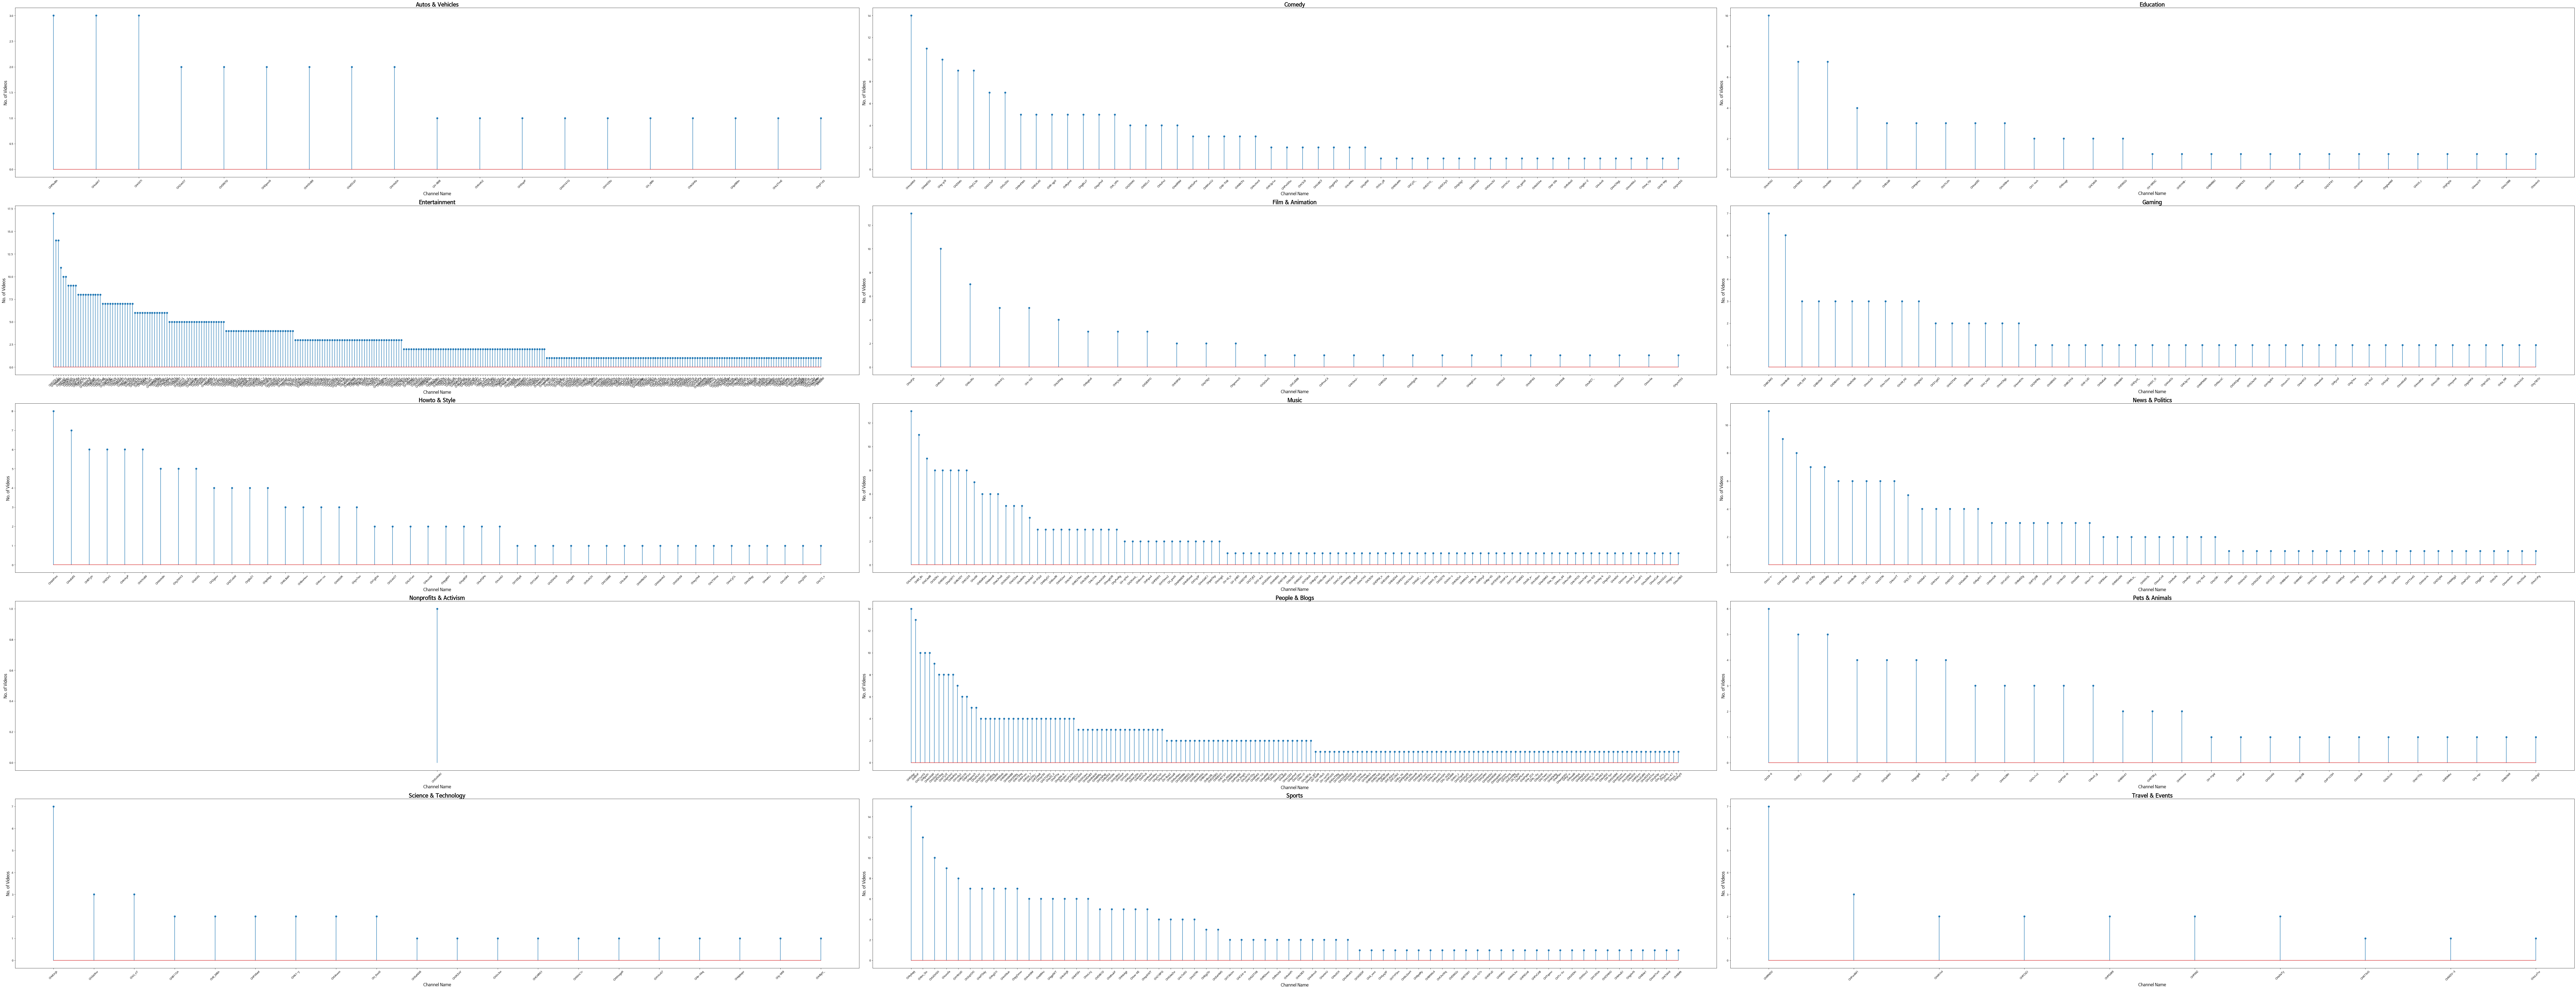

In [41]:
# figure 1

f, ax_list = plt.subplots(5,3,figsize=(130,50))

catlist = list(grouped_cat['category_name'].unique())
for i in range(len(ax_list)):
  for j in range(len(ax_list[i])):
    # Prepare Data
    cat = catlist.pop()
    data = grouped_cat[grouped_cat['category_name']==cat][['channel_id', 'no_of_video']]

    # Draw plot
    ax_list[i,j].stem(data['channel_id'], data['no_of_video'])
    
    # Title, Label, Ticks and Ylim
    labels = data['channel_id']
    ax_list[i,j].set_xticklabels(labels, rotation=45)
    ax_list[i,j].set_xlabel('Channel Name', fontsize=15)
    ax_list[i,j].set_ylabel('No. of Videos', fontsize=15)
    ax_list[i,j].set_title(cat, fontsize=20, fontweight='bold')


#plt.title('(전체기간) 카테고리 > 채널 > 비디오 개수')
#plt.savefig('figure1.png', dpi=300)

plt.tight_layout()

### (월별) 카테고리 > 채널 > 비디오 개수

In [36]:
# (월별) 카테고리별 채널별 비디오 개수 총람

grouped_m_cat = df.groupby(['published_month', 'category_name', 'channel_id']).size()
grouped_m_cat = grouped_m_cat.reset_index()
grouped_m_cat.columns = ['published_month', 'category_name', 'channel_id', 'no_of_video']
grouped_m_cat = grouped_m_cat.sort_values(['published_month', 'category_name', 'no_of_video'], ascending=[True, False, False])

grouped_m_cat.head(10)    # head()를 풀어 전체 데이터프레임을 확인할 수 있습니다.

,published_month,category_name,channel_id,no_of_video
62,3,Sports,CH2qVOO,1
63,3,Sports,CHCA4-e,1
64,3,Sports,CHZSNhO,1
65,3,Sports,CHoHirU,1
61,3,Science & Technology,CHUkuuo,1
59,3,Pets & Animals,CHOp66V,1
60,3,Pets & Animals,CHP1CQH,1
53,3,People & Blogs,CHaZS_X,2
55,3,People & Blogs,CHnet0I,2
47,3,People & Blogs,CHGiqkg,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves

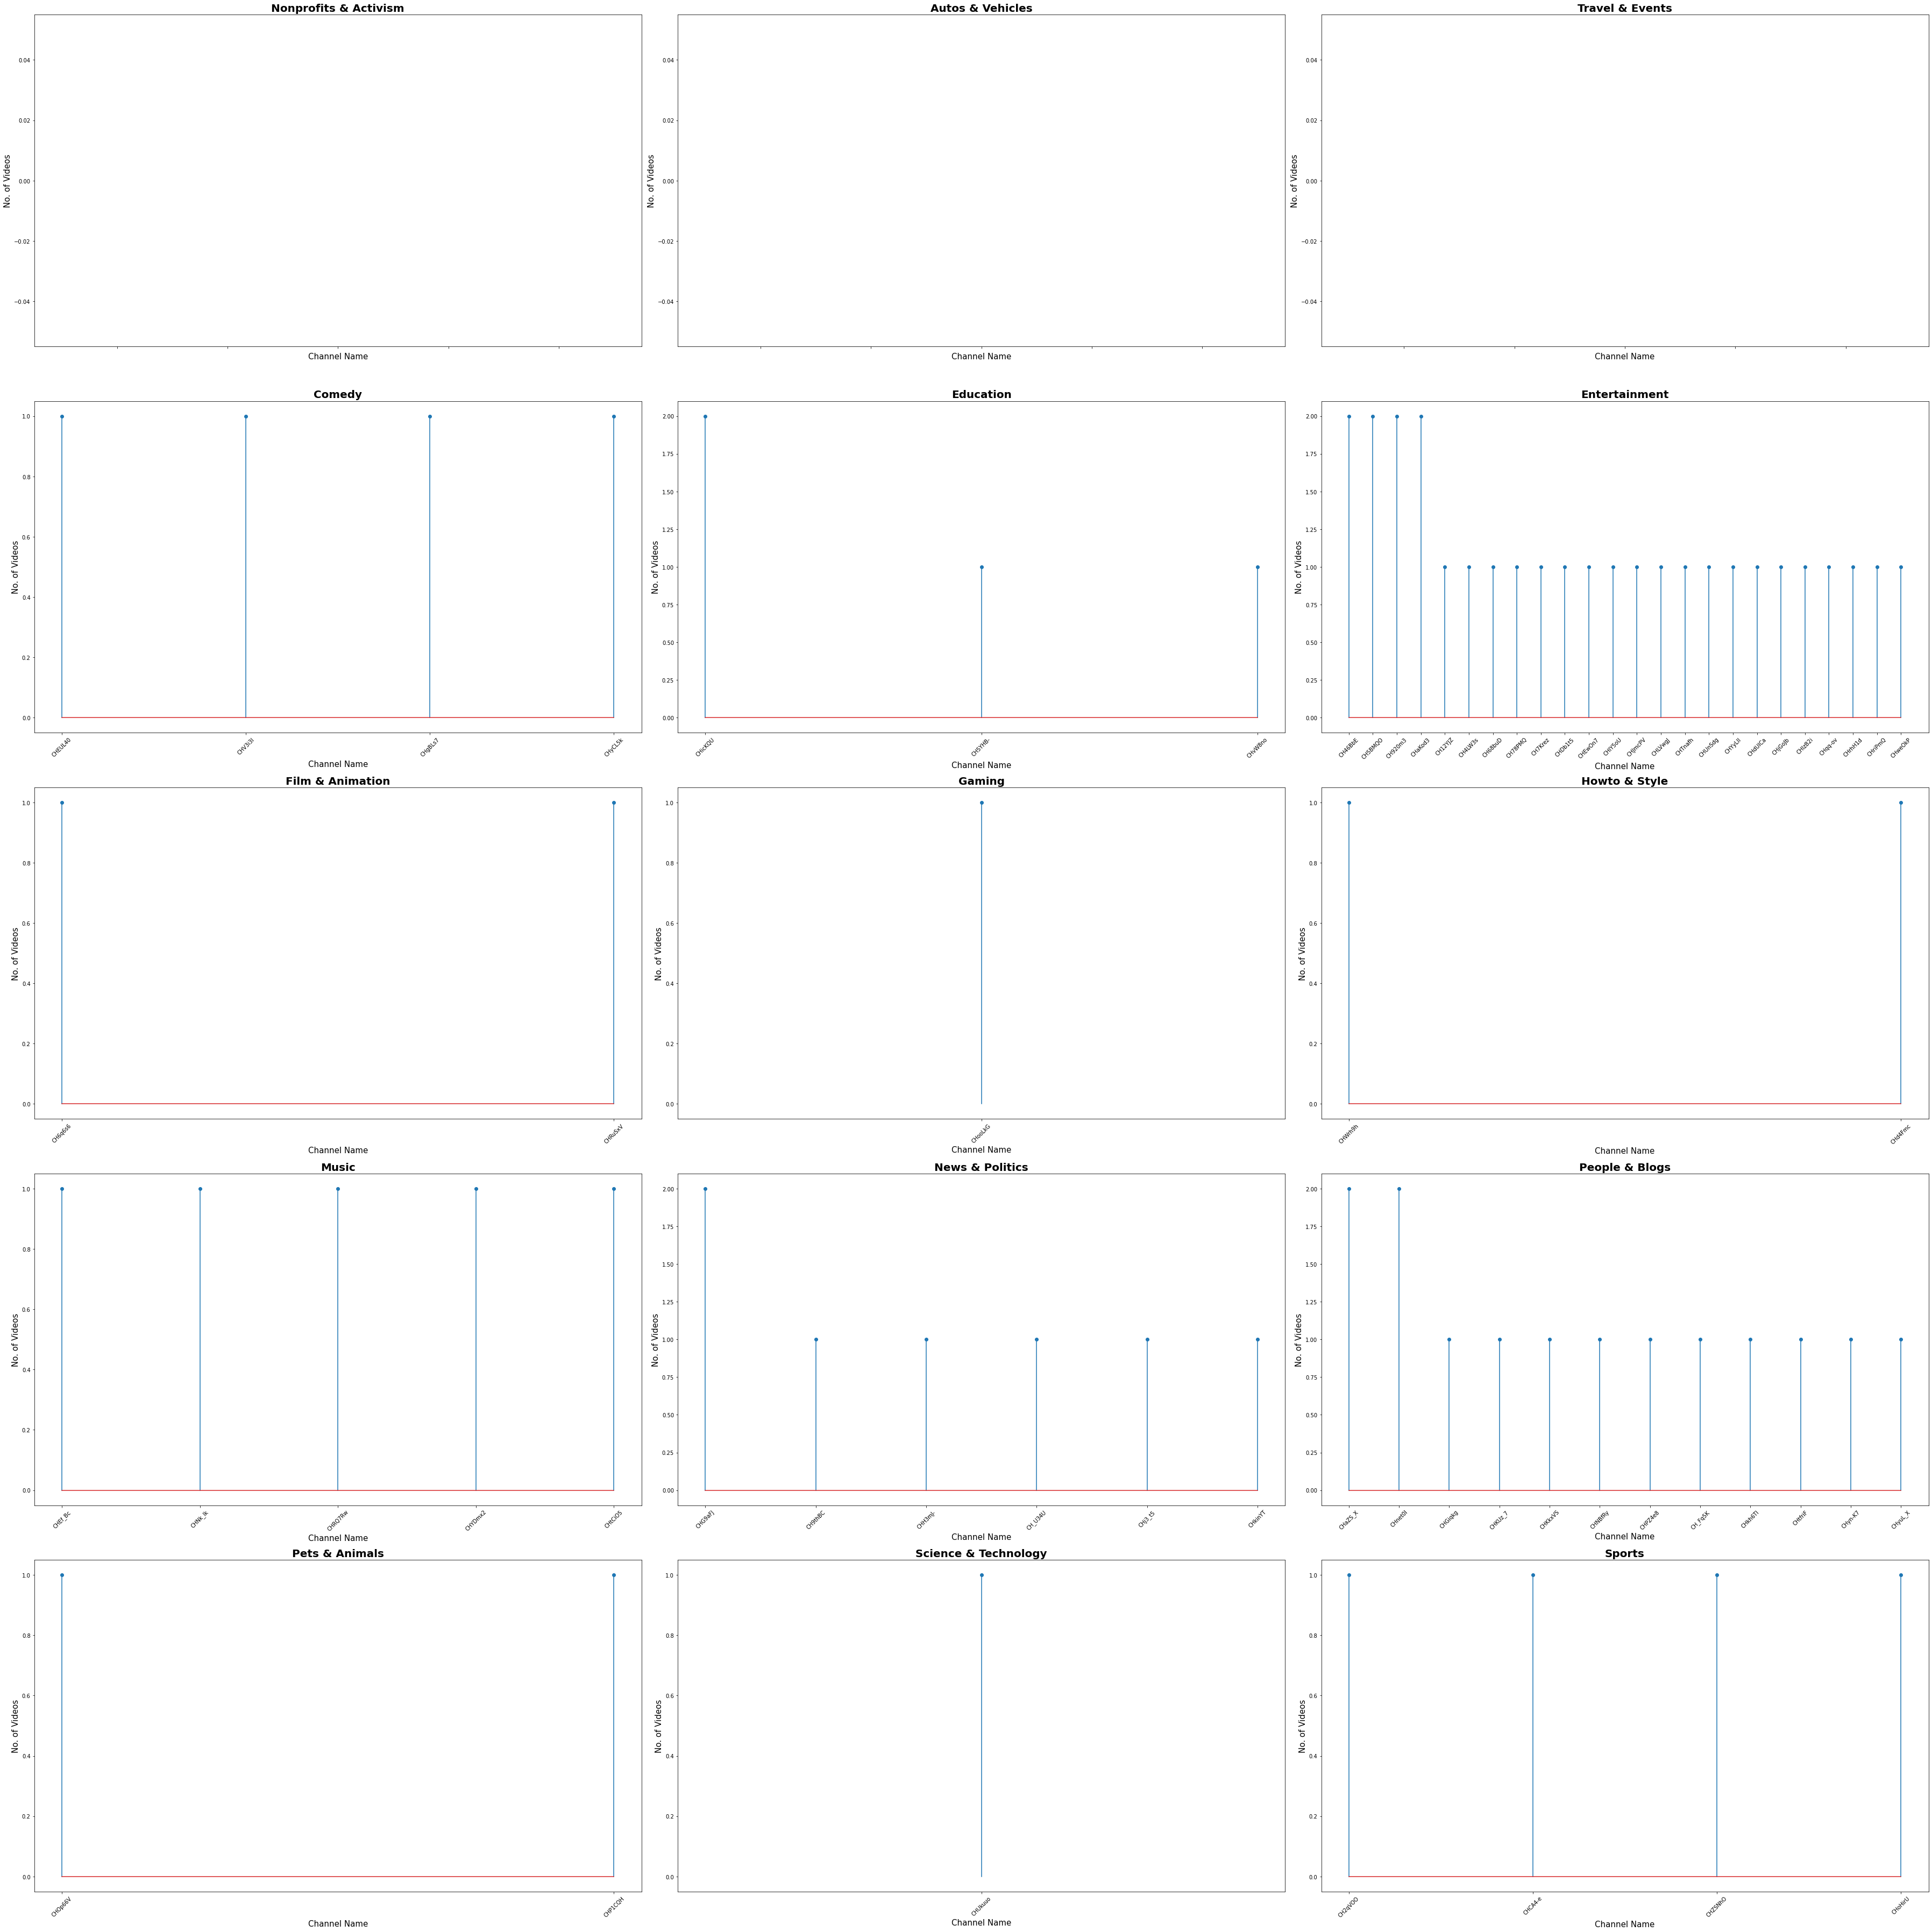

In [100]:
# figure 2 : 3월 > 카테고리 > 채널 > 비디오 수

f, ax_list = plt.subplots(5,3,figsize=(50,50))

catlist = list(grouped_m_cat['category_name'].unique())
for i in range(len(ax_list)):
  for j in range(len(ax_list[i])):
    # Prepare Data
    m = 3
    cat = catlist.pop()
    data = grouped_m_cat[(grouped_m_cat['category_name']==cat)&(grouped_m_cat['published_month']==m)][['channel_id', 'no_of_video']]

    # Draw plot
    x = data['channel_id']
    y = data['no_of_video']
    ax_list[i,j].stem(x,y)
    
    # Title, Label, Ticks and Ylim
    labels = data['channel_id']
    ax_list[i,j].set_xticklabels(labels, rotation=45)
    ax_list[i,j].set_xlabel('Channel Name', fontsize=15)
    ax_list[i,j].set_ylabel('No. of Videos', fontsize=15)
    ax_list[i,j].set_title(cat, fontsize=20, fontweight='bold')

#plt.savefig('figure2_3.png', dpi=300)
plt.tight_layout()

In [ ]:
# figure 2 : 4월 > 카테고리 > 채널 > 비디오 수

f, ax_list = plt.subplots(5,3,figsize=(50,50))

catlist = list(grouped_m_cat['category_name'].unique())
for i in range(len(ax_list)):
  for j in range(len(ax_list[i])):
    # Prepare Data
    m = 4
    cat = catlist.pop()
    data = grouped_m_cat[(grouped_m_cat['category_name']==cat)&(grouped_m_cat['published_month']==m)][['channel_id', 'no_of_video']]

    # Draw plot
    x = data['channel_id']
    y = data['no_of_video']
    ax_list[i,j].stem(x,y)
    
    # Title, Label, Ticks and Ylim
    labels = data['channel_id']
    ax_list[i,j].set_xticklabels(labels, rotation=45)
    ax_list[i,j].set_xlabel('Channel Name', fontsize=15)
    ax_list[i,j].set_ylabel('No. of Videos', fontsize=15)
    ax_list[i,j].set_title(cat, fontsize=20, fontweight='bold')

#plt.savefig('figure2_4월.png', dpi=300)
plt.tight_layout()

In [ ]:
# figure 2 : 5월 > 카테고리 > 채널 > 비디오 수

f, ax_list = plt.subplots(5,3,figsize=(50,50))

catlist = list(grouped_m_cat['category_name'].unique())
for i in range(len(ax_list)):
  for j in range(len(ax_list[i])):
    # Prepare Data
    m = 5
    cat = catlist.pop()
    data = grouped_m_cat[(grouped_m_cat['category_name']==cat)&(grouped_m_cat['published_month']==m)][['channel_id', 'no_of_video']]

    # Draw plot
    x = data['channel_id']
    y = data['no_of_video']
    ax_list[i,j].stem(x,y)
    
    # Title, Label, Ticks and Ylim
    labels = data['channel_id']
    ax_list[i,j].set_xticklabels(labels, rotation=45)
    ax_list[i,j].set_xlabel('Channel Name', fontsize=15)
    ax_list[i,j].set_ylabel('No. of Videos', fontsize=15)
    ax_list[i,j].set_title(cat, fontsize=20, fontweight='bold')

#plt.savefig('figure2_5월.png', dpi=300)
plt.tight_layout()

In [ ]:
# figure 2 : 6월 > 카테고리 > 채널 > 비디오 수

f, ax_list = plt.subplots(5,3,figsize=(50,50))

catlist = list(grouped_m_cat['category_name'].unique())
for i in range(len(ax_list)):
  for j in range(len(ax_list[i])):
    # Prepare Data
    m = 6
    cat = catlist.pop()
    data = grouped_m_cat[(grouped_m_cat['category_name']==cat)&(grouped_m_cat['published_month']==m)][['channel_id', 'no_of_video']]

    # Draw plot
    x = data['channel_id']
    y = data['no_of_video']
    ax_list[i,j].stem(x,y)
    
    # Title, Label, Ticks and Ylim
    labels = data['channel_id']
    ax_list[i,j].set_xticklabels(labels, rotation=45)
    ax_list[i,j].set_xlabel('Channel Name', fontsize=15)
    ax_list[i,j].set_ylabel('No. of Videos', fontsize=15)
    ax_list[i,j].set_title(cat, fontsize=20, fontweight='bold')

#plt.savefig('figure2_6월.png', dpi=300)
plt.tight_layout()

In [ ]:
# figure 2 : 7월 > 카테고리 > 채널 > 비디오 수

f, ax_list = plt.subplots(5,3,figsize=(50,50))

catlist = list(grouped_m_cat['category_name'].unique())
for i in range(len(ax_list)):
  for j in range(len(ax_list[i])):
    # Prepare Data
    m = 7
    cat = catlist.pop()
    data = grouped_m_cat[(grouped_m_cat['category_name']==cat)&(grouped_m_cat['published_month']==m)][['channel_id', 'no_of_video']]

    # Draw plot
    x = data['channel_id']
    y = data['no_of_video']
    ax_list[i,j].stem(x,y)
    
    # Title, Label, Ticks and Ylim
    labels = data['channel_id']
    ax_list[i,j].set_xticklabels(labels, rotation=45)
    ax_list[i,j].set_xlabel('Channel Name', fontsize=15)
    ax_list[i,j].set_ylabel('No. of Videos', fontsize=15)
    ax_list[i,j].set_title(cat, fontsize=20, fontweight='bold')

#plt.savefig('figure2_7월.png', dpi=300)
plt.tight_layout()

### (월별) TOP10 채널 - 비디오 개수 기준

| published_month | channel_id | no_of_video | 
| :------------: | :--------: | :---------: | 
| 3 | CHlRNDV | 1 |
| 3 | CHtm_Qo | 2 | 
| ... |
| 3 | BSFfgsf | 10 | 
| 4 | BSFfgsf | 1 | 

In [105]:
# (월별) 채널별 비디오 개수 집계 및 순위 부여

grouped_m_top = df.groupby(['published_month', 'channel_id']).size()   # 월별 > 채널별 > 비디오 개수로 그룹화
grouped_m_top10 = grouped_m_top.reset_index()

In [107]:
# (월별) 채널 비디오 개수 TOP10 총람

grouped_m_top10.columns = ['published_month', 'channel_id', 'no_of_video']      # 컬럼명 변경 
grouped_m_top10 = grouped_m_top10.sort_values(['published_month', 'no_of_video'], ascending=[True, False]).reset_index(drop=True) # 월별 순위 정렬
grouped_m_top10 = grouped_m_top10.groupby(['published_month']).head(10)         # 상위 10개 채널 추리기

grouped_m_top10.head(10)    # head()를 풀어 전체 데이터프레임을 확인할 수 있습니다.

,published_month,channel_id,no_of_video
0,3,CH46BbE,2
1,3,CH5BMQO,2
2,3,CH920m3,2
3,3,CHG9aFJ,2
4,3,CHaKod3,2
5,3,CHaZS_X,2
6,3,CHicKQU,2
7,3,CHnet0I,2
8,3,CH12YJZ,1
9,3,CH2qVOO,1


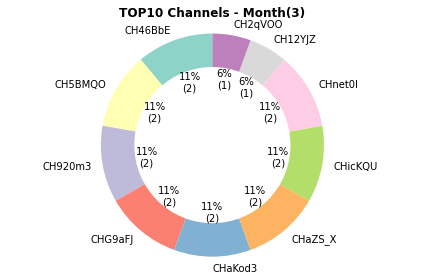

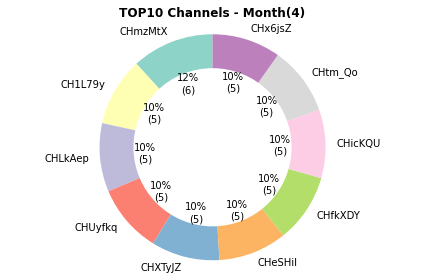

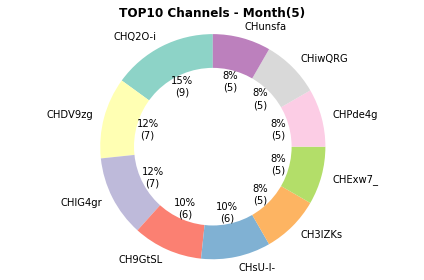

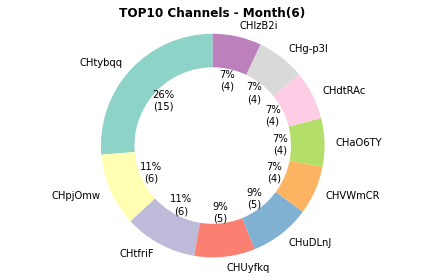

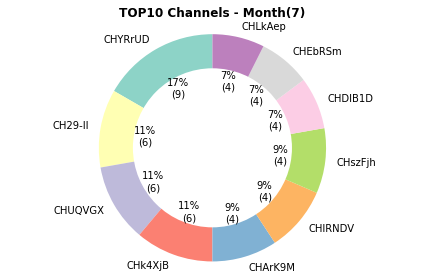

In [191]:
# figure3 : (월별) TOP10 채널
monthlist = [3,4,5,6,7]
for m in monthlist:
    # Prepare Data
    mdf = grouped_m_top10[grouped_m_top10['published_month']==m][['channel_id','no_of_video']]
    labels = mdf['channel_id']
    sizes = mdf['no_of_video']

    # Draw Plot
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.0f}%\n({:d})".format(pct, absolute)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=plt.cm.Set3.colors, autopct=lambda pct: func(pct, sizes), startangle=90)

    # Decorate
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(f'TOP10 Channels - Month({m})', fontsize=12, fontweight='bold')
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig(f'figure3_m{m}.png', dpi=300)
    plt.show()

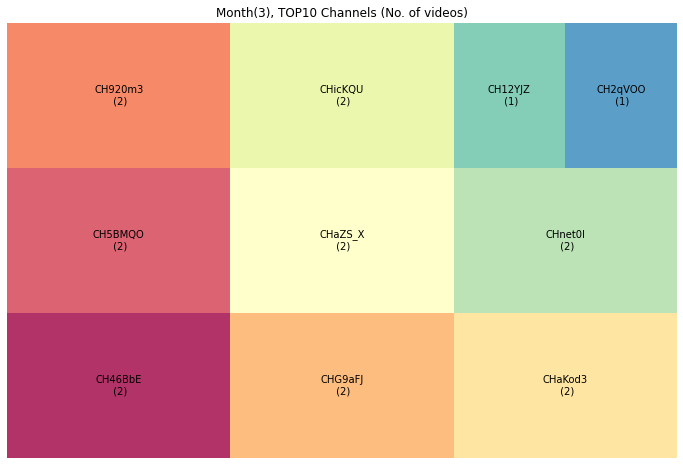

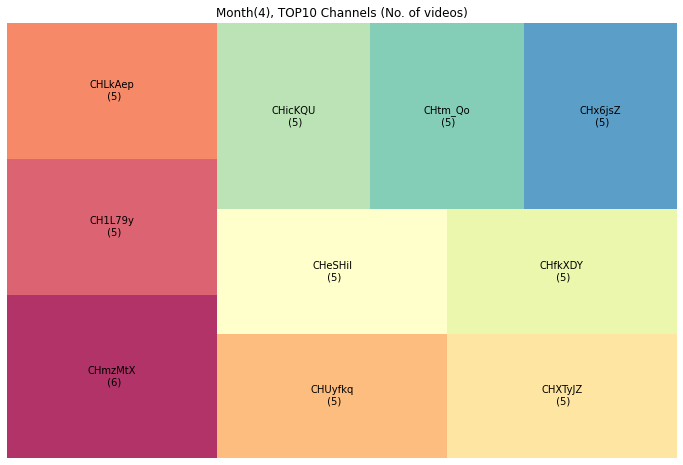

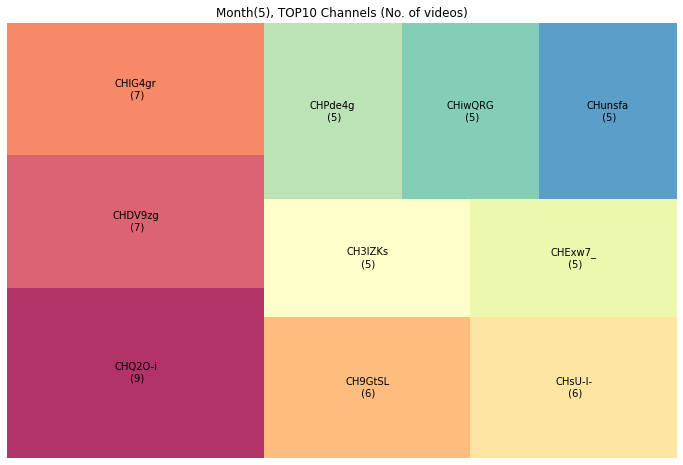

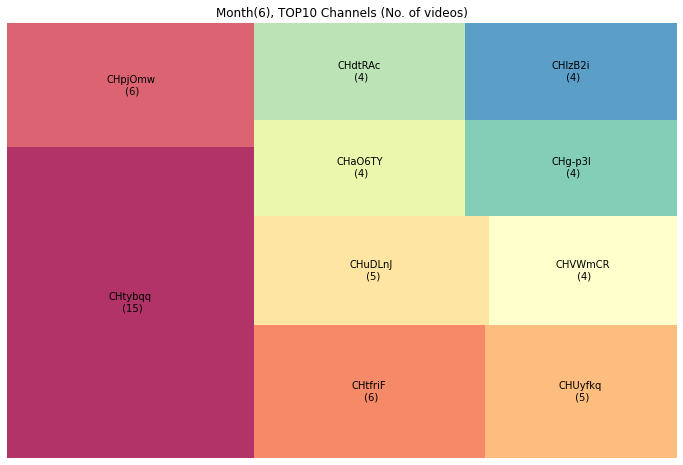

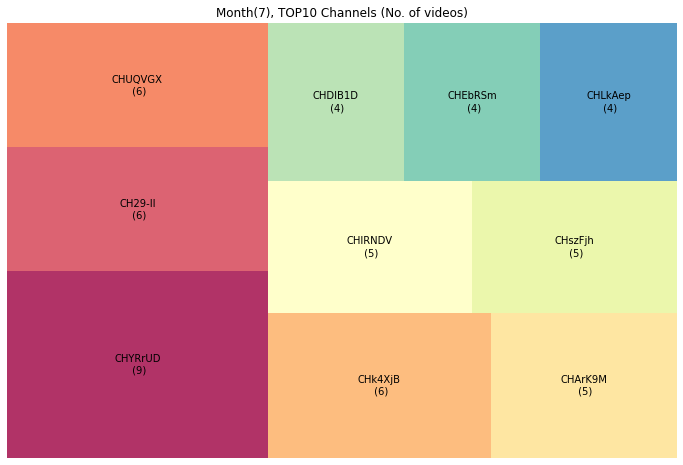

In [135]:
# figure3 : (월별) TOP10 채널

monthlist = [3,4,5,6,7]
for m in monthlist:
  # Prepare Data
  mdf = grouped_m_top10[grouped_m_top10['published_month']==m][['channel_id','no_of_video']]
  x = mdf['channel_id']
  y = mdf['no_of_video']

  labels = mdf.apply(lambda x: str(x['channel_id']) + "\n (" + str(x['no_of_video']) + ")", axis=1)
  sizes = y.values.tolist()
  colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

  # Draw Plot
  plt.figure(figsize=(12,8))
  squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

  # Decorate
  plt.title(f'Month({m}), TOP10 Channels (No. of videos)', fontsize=20, fontweight='bold')
  plt.axis('off')
  #plt.savefig(f'figure3_m{m}.png', dpi=300)
  plt.show()

### (주별) TOP5 채널 - 비디오 개수 기준   
| published_month | published_weekofmonth | channel_id | no_of_video |
| :------------: | :-----------: | :--------: | :--: |
| 3 | 1 | CH3dJKw | 1 |
| 3 | 1 | WFEGSED | 2 |
| ... |
| 3 | 1 | CH3syww | 5 |
|3 | 2 | Csfeqxc | 1 |

In [153]:
# (주별) 채널별 비디오 개수 집계 및 순위 부여

grouped_w_top = df.groupby(['published_month', 'published_weekofmonth', 'channel_id']).size()   # 월별 > 주별 > 채널별 > 비디오 개수로 그룹화
grouped_w_top5 = grouped_w_top.reset_index()

In [155]:
# (주별) 채널 비디오 개수 TOP5 총람

grouped_w_top5.columns = ['published_month', 'published_weekofmonth', 'channel_id', 'no_of_video']      # 컬럼명 변경 
grouped_w_top5 = grouped_w_top5.sort_values(['published_month', 'published_weekofmonth', 'no_of_video'], ascending=[True, True, False]).reset_index(drop=True) # 월별 순위 정렬
grouped_w_top5 = grouped_w_top5.groupby(['published_month', 'published_weekofmonth']).head(5)         # 상위 5개 채널 추리기

grouped_w_top5.head()

,published_month,published_weekofmonth,channel_id,no_of_video
0,3,4,CHnet0I,2
1,3,4,CH2qVOO,1
2,3,4,CH7Krez,1
3,3,4,CHCA4-e,1
4,3,4,CHGiqkg,1


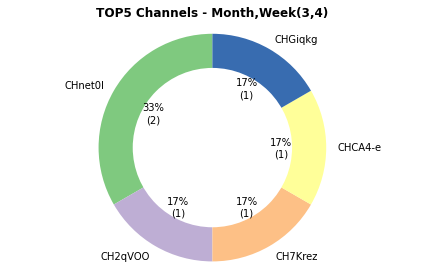

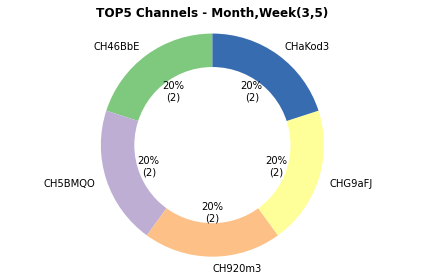

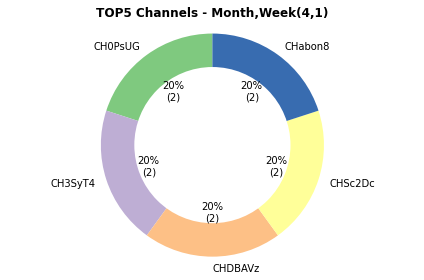

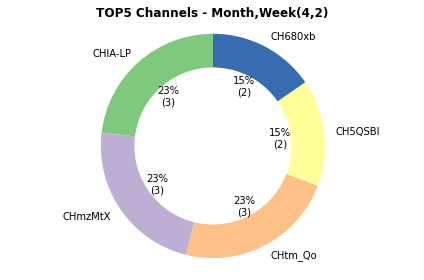

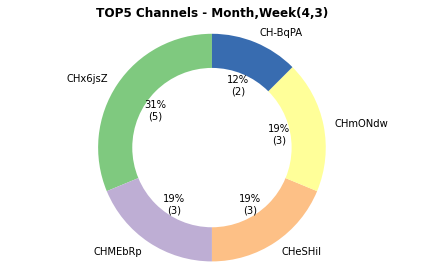

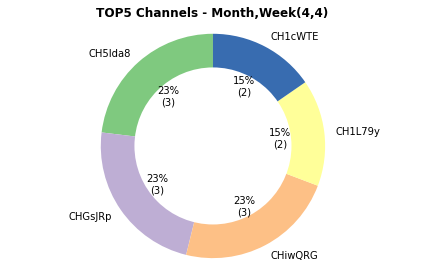

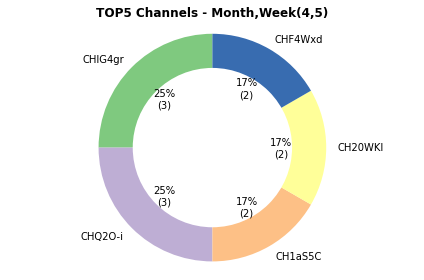

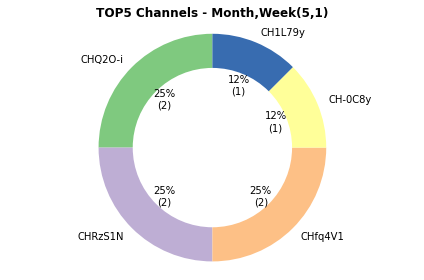

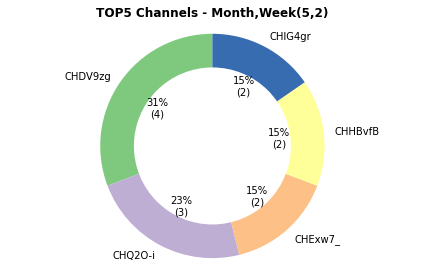

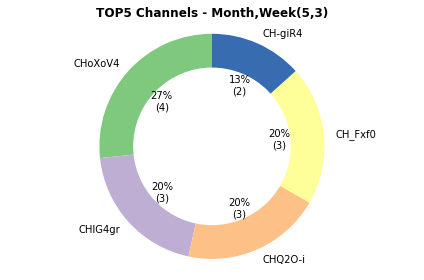

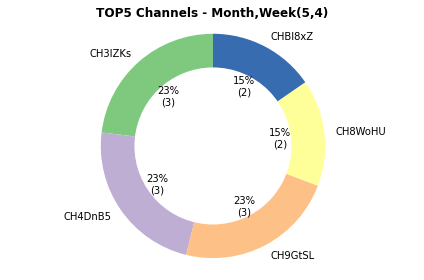

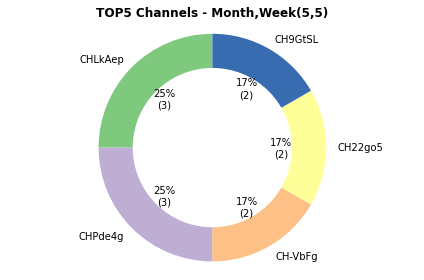

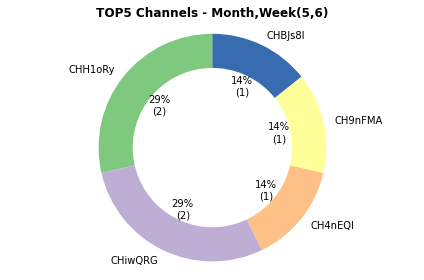

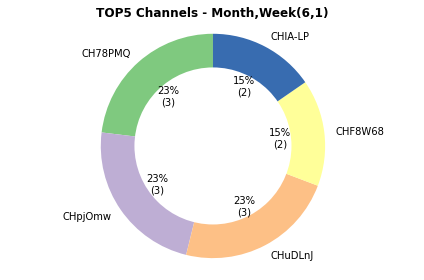

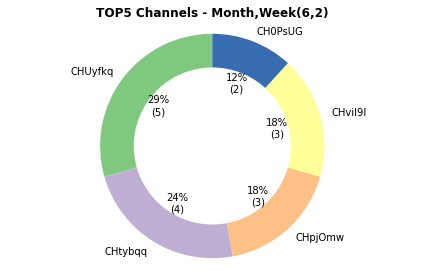

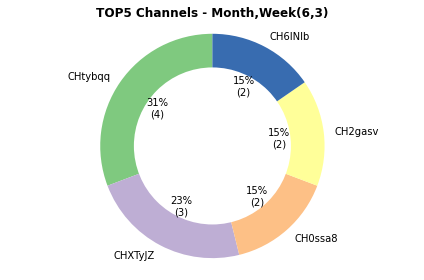

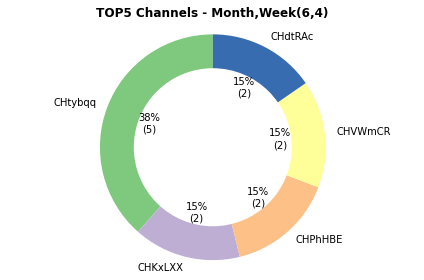

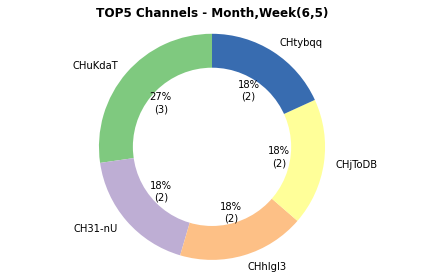

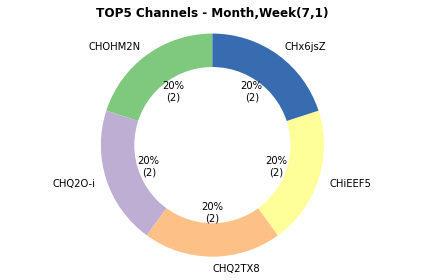

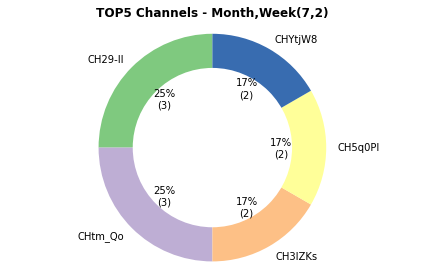

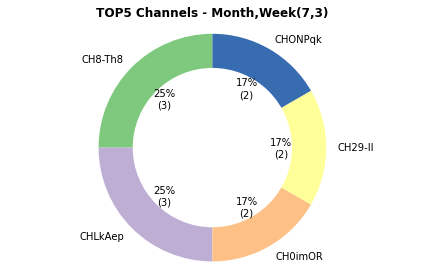

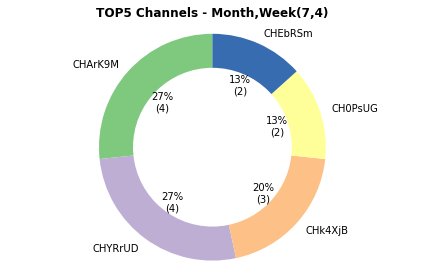

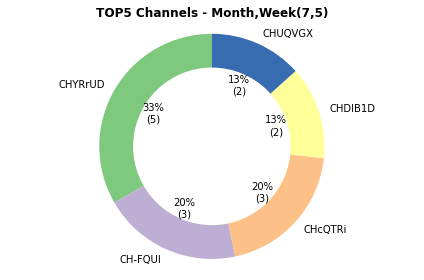

In [186]:
# figure4 : (주별) TOP5 채널
monthlist = [3,4,5,6,7]
for m in monthlist:
  weeklist = sorted(list(grouped_w_top5[grouped_w_top5['published_month'] == m]['published_weekofmonth'].unique()))
  for w in weeklist:
    # Prepare Data
    wdf = grouped_w_top5[(grouped_w_top5['published_month'] == m)&(grouped_w_top5['published_weekofmonth'] == w)][['channel_id','no_of_video']]
    labels = wdf['channel_id']
    sizes = wdf['no_of_video']

    # Draw Plot
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.0f}%\n({:d})".format(pct, absolute)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=plt.cm.Accent.colors, autopct=lambda pct: func(pct, sizes), startangle=90)

    # Decorate
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(f'TOP5 Channels - Month,Week({m},{w})', fontsize=12, fontweight='bold')
    ax1.axis('equal')  
    plt.tight_layout()
    #plt.savefig(f'figure4_m{m}_w{w}.png', dpi=300)
    plt.show()

In [ ]:
# figure3 : (주별) TOP5 채널
import squarify

monthlist = [3,4,5,6,7]
for m in monthlist:
  # Prepare Data
  mdf = grouped_m_top10[grouped_m_top10['published_month']==m][['channel_id','no_of_video']]
  x = mdf['channel_id']
  y = mdf['no_of_video']

  labels = mdf.apply(lambda x: str(x['channel_id']) + "\n (" + str(x['no_of_video']) + ")", axis=1)
  sizes = y.values.tolist()
  colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

  # Draw Plot
  plt.figure(figsize=(12,8))
  squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

  # Decorate
  plt.title(f'Month({m}), TOP10 Channels (No. of videos)')
  plt.axis('off')
  plt.show()

### (월별) 카테고리별 태그 키워드 순위
| published_month | category_name | tag_keyword | freq | rank |
| :-------------: | :-----------: | :---------: | :--: | :--: |
| 3 | Comedy | '키워드1' | 10 | 1 |
| 3 | Comedy | '키워드2' | 5 | 2 |
|...|
| 3 | Animal | '키워드3' | 10 | 1 |


In [19]:
# tag keyword 빈도 확인을 위해 새로운 데이터 프레임을 만든다.

df_tag = df[['published_month', 'category_name', 'video_id', 'tags']]
df_tag.head()

,published_month,category_name,video_id,tags
0,7,Entertainment,V-0db,"[SiriusXM, Sirius XM, Sirius, SXM, BIGHIT, 빅히트..."
1,6,Entertainment,V-1XL,"[치킨불냉면, 치킨, 불냉면, 냉면]"
2,7,Entertainment,V-4fa,[]
3,6,Sports,V-5ip,"[News Network, SBS SPORTSMUG, SPORTSMUG, 스포츠머그..."
4,7,Sports,V-5jn,"[이천수, 심판도전기, 축구심판]"


In [20]:
# Getkeyword - 특정 월과 카테고리를 받아 키워드와 그 빈도를 계산한다.

def Getkeyword(df, month, category):
  from collections import Counter

  tags = []
  for index in range(df.shape[0]):
    if df['published_month'].loc[index] == month:
      if df['category_name'].loc[index] == category:
        tags.append(df['tags'].loc[index])
  tags = sum(tags, [])

  return dict(Counter(tags))

In [21]:
# Getmonthkeyword - 특정 월과 카테고리별로 키워드와 그 빈도를 dict에 저장한다. 

def Getmonthkeyword(df, month, category_list):
  freqlist = []
  for c in category_list:
    subdict = {'published_month': month, 
               'category_name': c, 
               'tags': Getkeyword(df, month, c)}
    freqlist.append(subdict)

  return freqlist

In [22]:
category_list = df['category_name'].unique()

m3 = Getmonthkeyword(df_tag, 3, category_list)
m4 = Getmonthkeyword(df_tag, 4, category_list)
m5 = Getmonthkeyword(df_tag, 5, category_list)
m6 = Getmonthkeyword(df_tag, 6, category_list)
m7 = Getmonthkeyword(df_tag, 7, category_list)

In [23]:
# dict를 받아 데이터프레임 df_tags을 만든다.

def dicttodataframe(listofdict):

  df = pd.DataFrame()
  for i in listofdict:
    temp = pd.DataFrame.from_dict(i['tags'], orient='index', columns=['freq'])
    temp['published_month'] = i['published_month']
    temp['category_name'] = i['category_name']
    df = pd.concat([df, temp])

  return df

In [24]:
# 결합할 모든 데이터프레임을 준비한다.

df_m3_tags = dicttodataframe(m3)
df_m4_tags = dicttodataframe(m4)
df_m5_tags = dicttodataframe(m5)
df_m6_tags = dicttodataframe(m6)
df_m7_tags = dicttodataframe(m7)

In [25]:
# 최종 데이터프레임을 정리한다.

df_tags = pd.concat([df_m3_tags, df_m4_tags, df_m5_tags, df_m6_tags, df_m7_tags])
df_tags = df_tags.reset_index()   # 인덱스에 위치한 키워드를 컬럼으로 이동
df_tags.columns = ['keyword', 'freq', 'published_month', 'category_name']   # 컬럼명 지정
df_tags = df_tags[['published_month', 'category_name', 'keyword', 'freq']]  # 컬럼위치 변경
df_tags = df_tags[df_tags['keyword'] != '']   # 공백 키워드 제거
df_tags = df_tags.sort_values(['published_month', 'category_name', 'freq'], ascending=[True, True, False])  # 빈도 내림차순 정렬


In [26]:
# (월별) 카테고리별 키워드 빈도수 TOP10 총람

grouped_tags = df_tags.groupby(['published_month', 'category_name']).head(10)   # 월별 > 카테고리별 > 키워드 빈도수로 그룹화
grouped_tags = grouped_tags.reset_index()
grouped_tags

,index,published_month,category_name,keyword,freq
0,1122,3,Comedy,웃긴영상,2
1,1123,3,Comedy,시트콤,2
2,1137,3,Comedy,몰카,2
3,1110,3,Comedy,#깨방정,1
4,1111,3,Comedy,#정승빈,1
5,1112,3,Comedy,#몰카,1
6,1113,3,Comedy,#미녀,1
7,1114,3,Comedy,#개그맨,1
8,1115,3,Comedy,#존잘남,1
9,1116,3,Comedy,#존예녀,1


In [36]:
import os

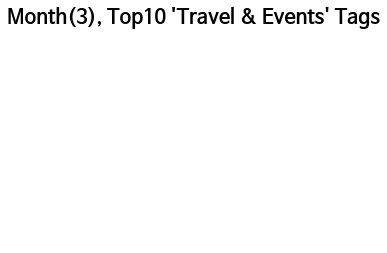

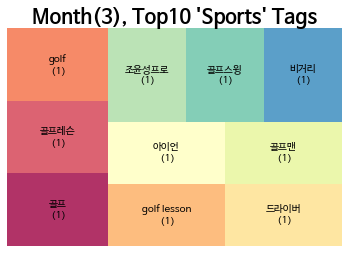

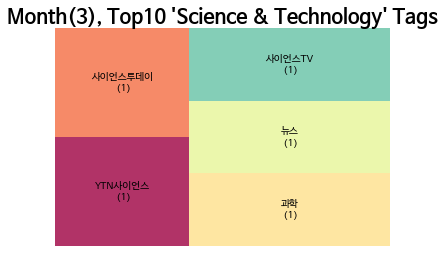

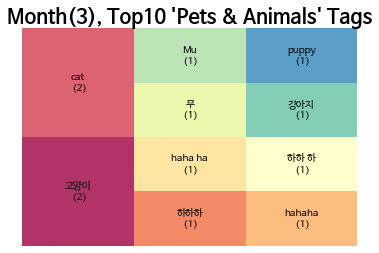

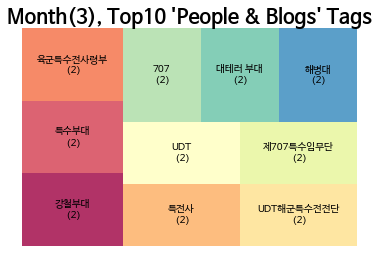

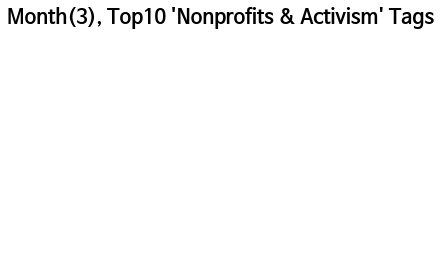

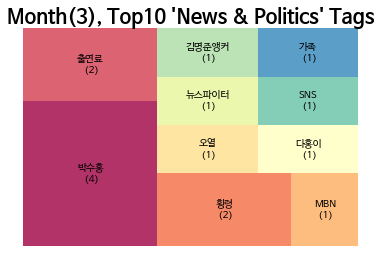

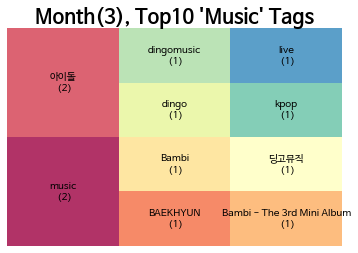

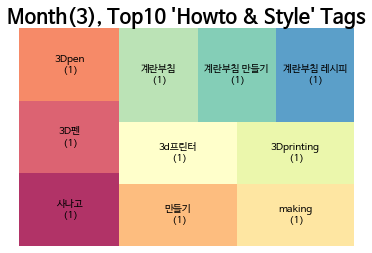

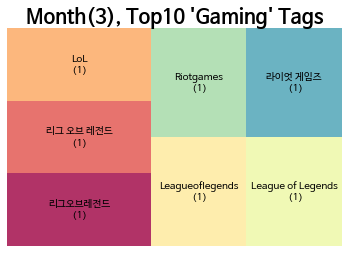

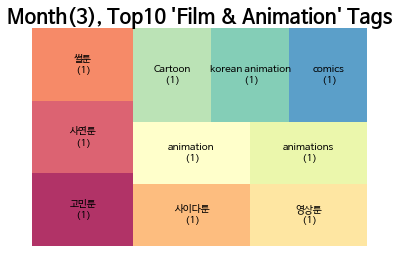

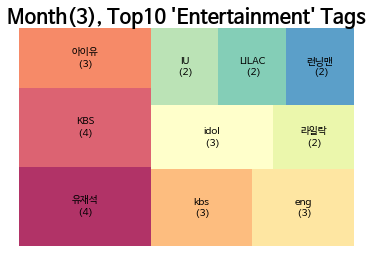

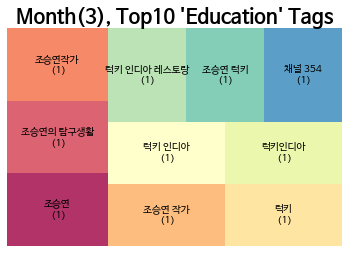

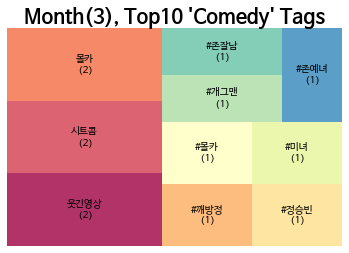

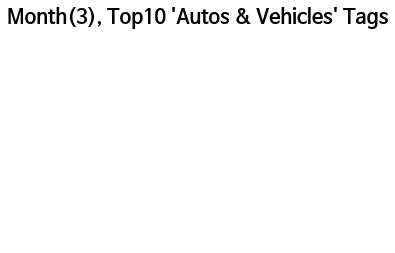

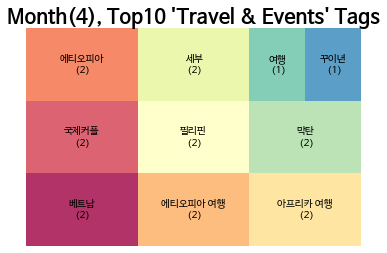

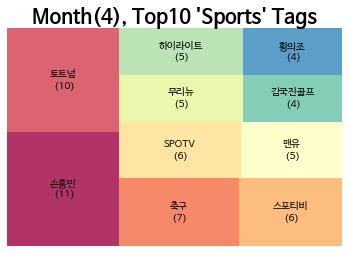

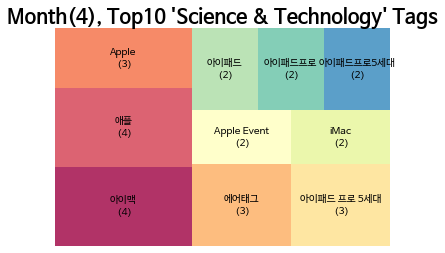

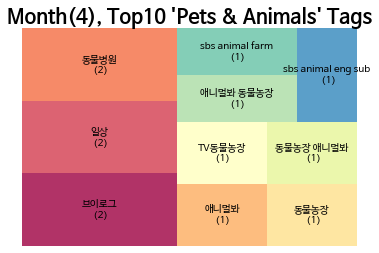

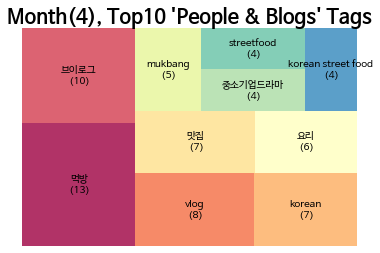

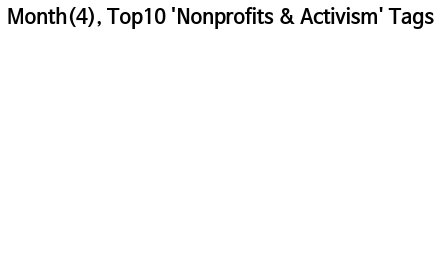

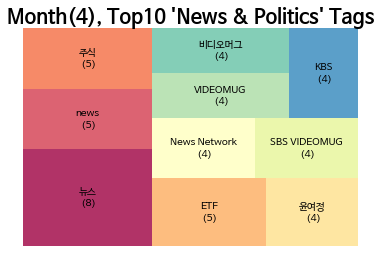

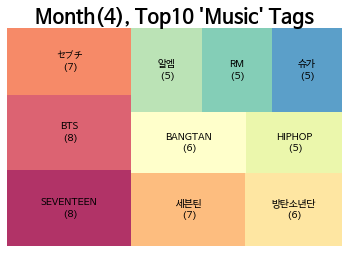

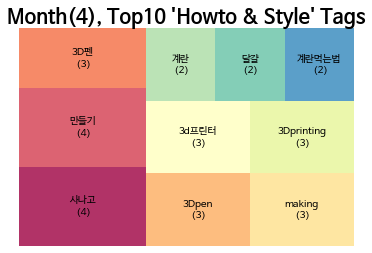

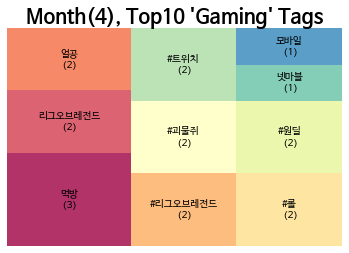

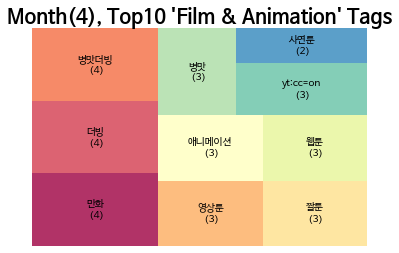

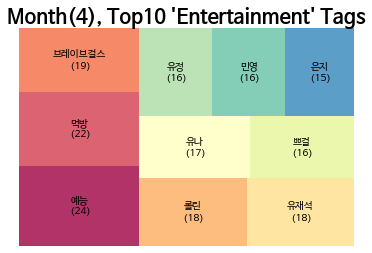

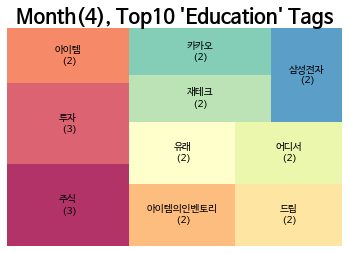

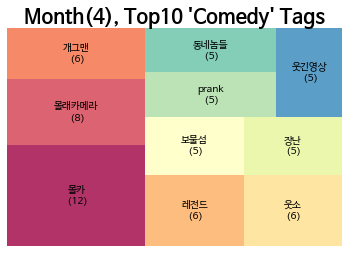

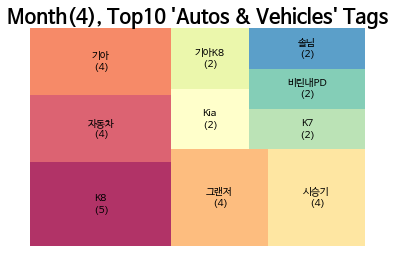

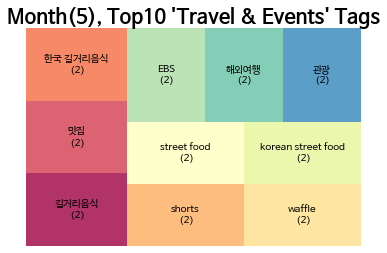

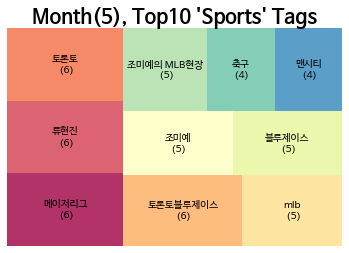

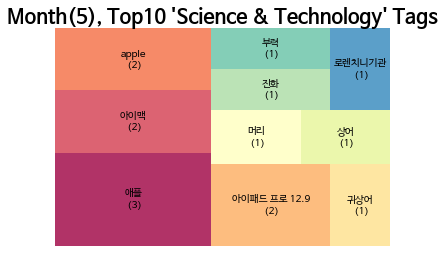

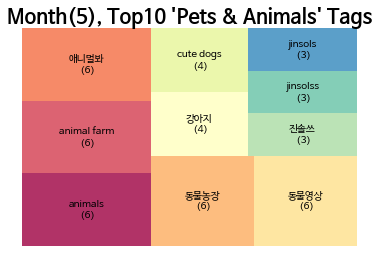

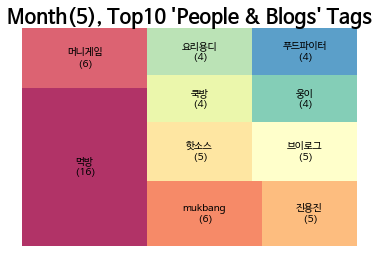

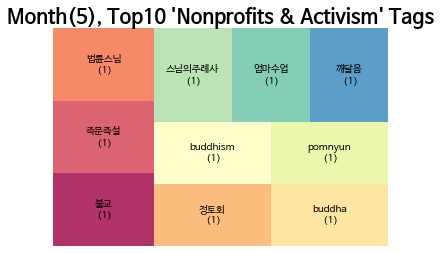

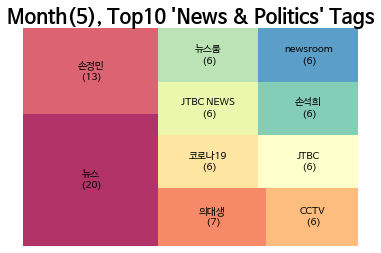

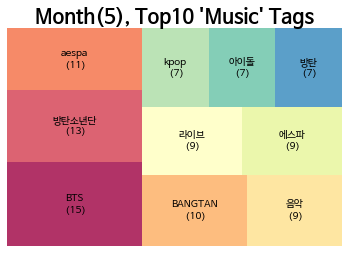

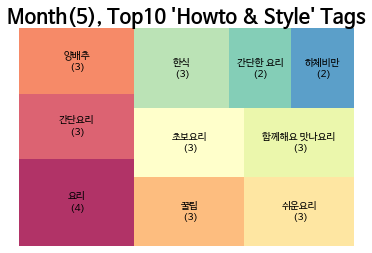

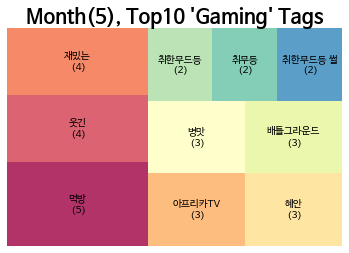

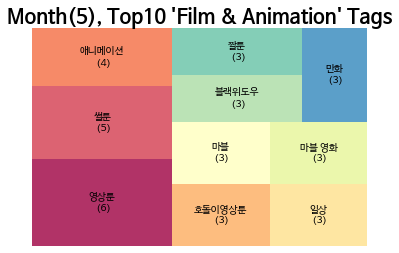

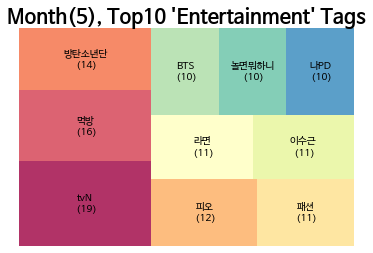

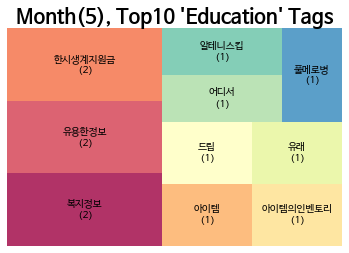

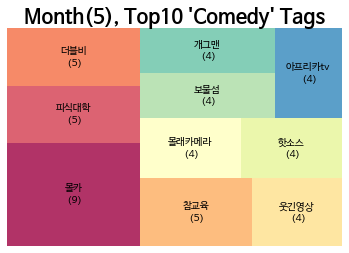

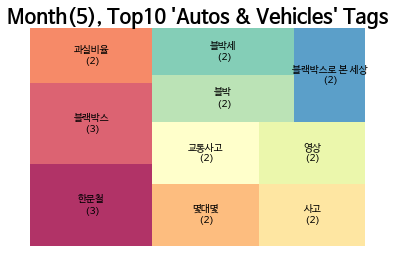

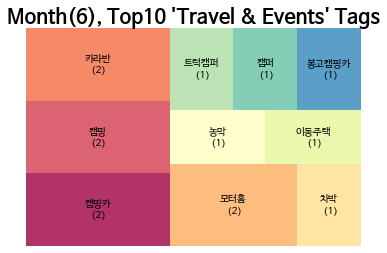

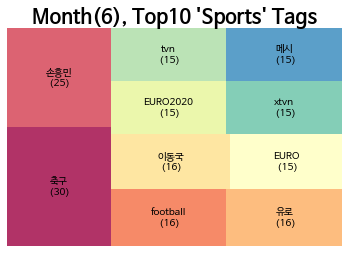

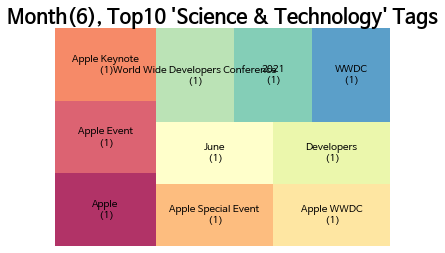

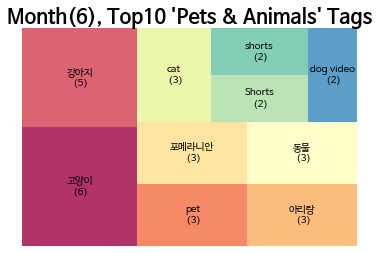

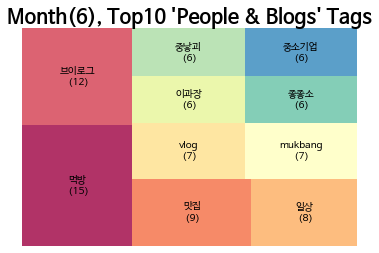

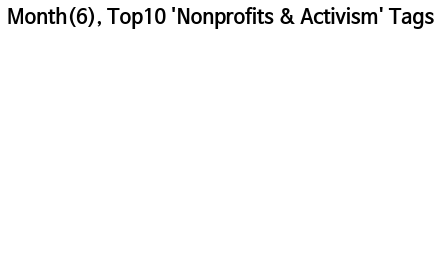

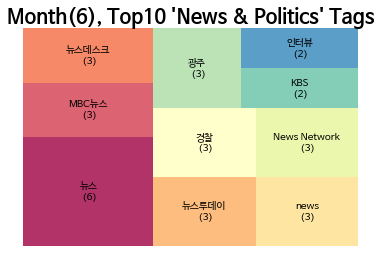

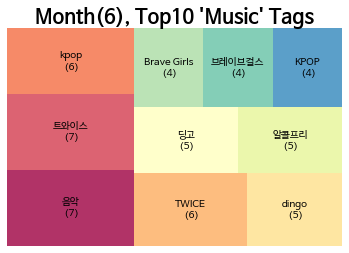

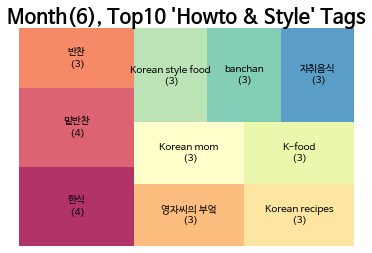

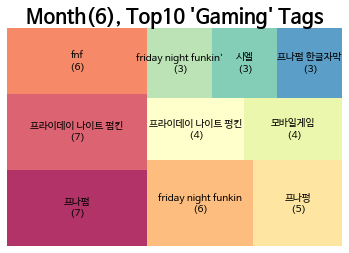

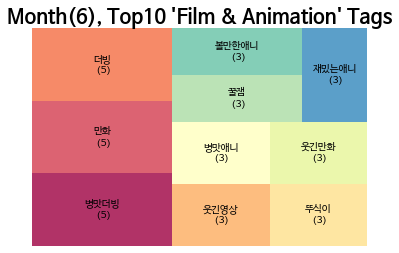

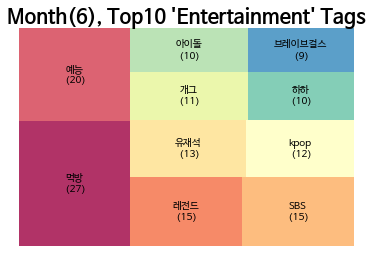

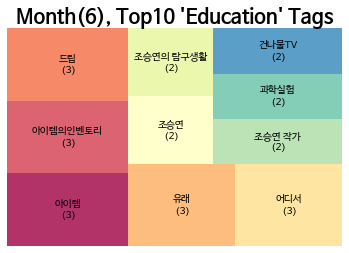

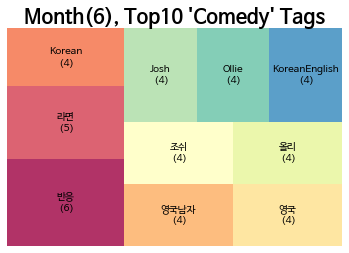

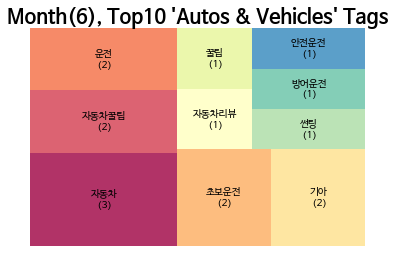

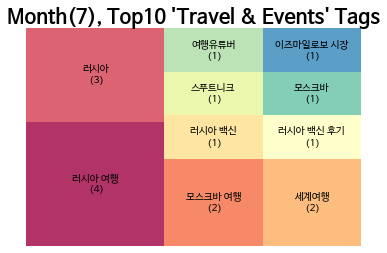

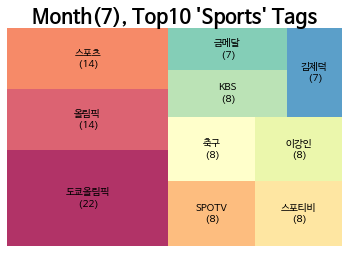

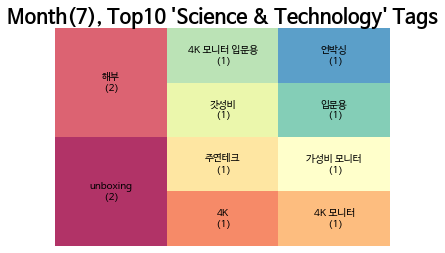

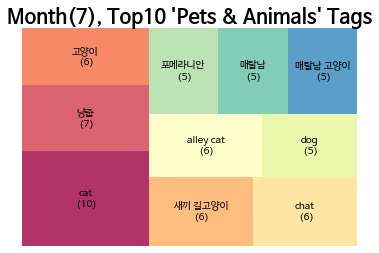

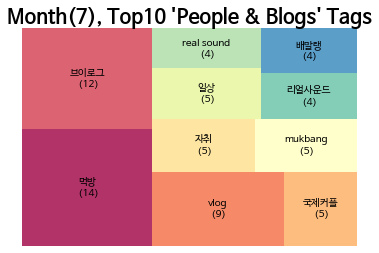

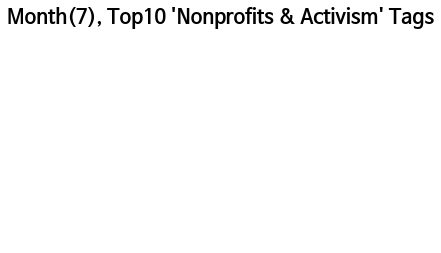

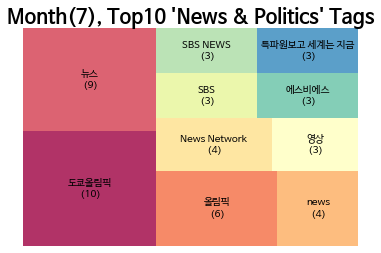

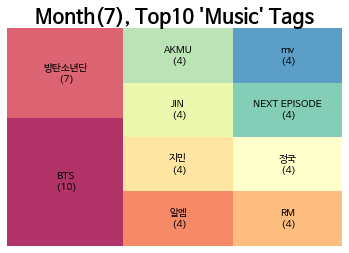

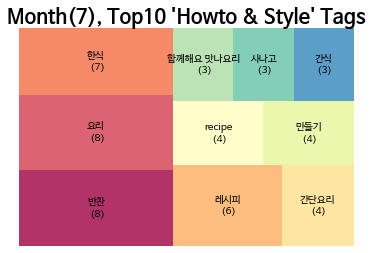

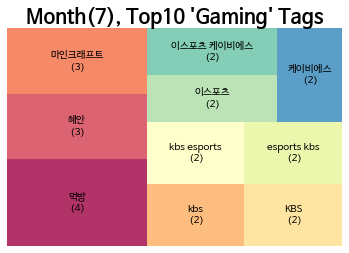

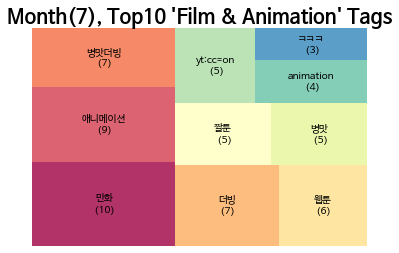

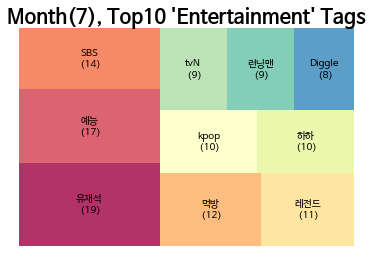

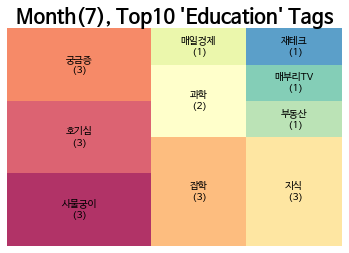

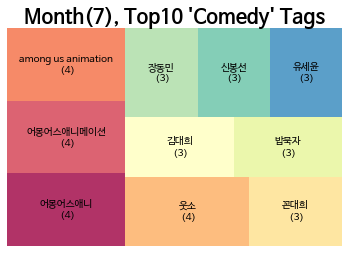

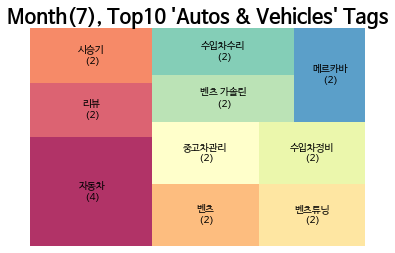

In [38]:
# figure5 : (월별) 카테고리별 태그 키워드 순위

monthlist = [3,4,5,6,7]
for m in monthlist:
  catlist = sorted(list(grouped_tags['category_name'].unique()), reverse=True)
  for c in catlist:
    # Prepare Data
    mcdf = grouped_tags[(grouped_tags['published_month']==m)&(grouped_tags['category_name']==c)][['keyword', 'freq']]
    x = mcdf['keyword']
    y = mcdf['freq']

    labels = mcdf.apply(lambda x: str(x['keyword']) + "\n (" + str(x['freq']) + ")", axis=1)
    sizes = y.values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    # Draw Plot
    plt.figure()
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    # Decorate
    plt.title(f'Month({m}), Top10 \'{c}\' Tags', fontsize=20, fontweight='bold')
    plt.axis('off')
    #plt.savefig(f'figure5_m{m}_c{c}.png', dpi=300)
    plt.show()

# **Q2. Engagement Index**
- **What affects the YouTube Engagement Rate?**   
    There are many factors which affect the performance of YouTube videos organically, here are just a few:
  - The way people interact with your videos (likes vs dislikes vs comments vs shares)
  - Posting controversial videos or topics designed to elicit a reaction
  - How long people watch your video on average
  - Number of subscribers
  - Changes to YouTube's algorithm
  - Video title, video description and use of hashtags

- **Benchmark**   
  There is a standard way to calculate the Engagement Rate (ER) on YouTube.
  * `(Likes + Comments + Shares)` / `Video Views`
  * `No. of cliks on interactive elements` / `No. of times an advt. is shown`   
  (Trunfio, M., Rossi, S. Conceptualising and measuring social media engagement: A systematic literature review. Ital. J. Mark. 2021, 267–292 (2021))

- **Suggetion**   
  Since we do not have the information on the no. of cliks on interactive elements and the no. of times an advt. shown, we would like to device a similar engageent index based on the info we have in the data.    
  Our idea is based on the intution that the engagement is related to the 

  1. diff_likes_dislikes
  2. diff_views
  3. diff_comments
  4. diff_subscribers
  5. (1+2+3+4) / (Trending duration days*24)



In [104]:
# 1. diff_likes_dislikes

diff_likes = df['off_likes'] - df['on_likes']
diff_dislikes = df['off_dislikes'] - df['on_dislikes']

diff_likes_dislikes = abs(diff_likes - diff_dislikes) / (diff_likes + diff_dislikes)
diff_likes_dislikes = diff_likes_dislikes.fillna(0)
np.histogram(diff_likes_dislikes)     # (range: 0~1)

(array([ 755,    3,    3,    9,   12,   15,   39,  102,  446, 1260]),
 array([0.        , 0.09994135, 0.1998827 , 0.29982405, 0.3997654 ,
        0.49970674, 0.59964809, 0.69958944, 0.79953079, 0.89947214,
        0.99941349]))

In [105]:
# 2. diff_views      
from numpy import inf

diff_views = np.log(df['off_views'] - df['on_views'])
diff_views[diff_views == -inf] = 0
np.histogram(diff_views)   # (range: 0~18)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([ 740,    0,    0,    0,    1,  469, 1065,  334,   30,    5]),
 array([ 0.        ,  1.88367534,  3.76735068,  5.65102602,  7.53470135,
         9.41837669, 11.30205203, 13.18572737, 15.06940271, 16.95307805,
        18.83675339]))

In [ ]:
# 3. diff_comments

diff_comments = np.log(df['off_comments'] - df['on_comments'])
diff_comments[diff_comments == -inf] = 0
diff_comments

In [ ]:
# 4. diff_subscribers

diff_subscribers = np.log(df['off_channel_subscribers'] - df['on_channel_subscribers'])
diff_subscribers[diff_subscribers == -inf] = 0

diff_subscribers

In [106]:
# 5. (1+2+3+4) / (Trending duration days*24)

a = (diff_likes_dislikes + diff_views + diff_comments + diff_subscribers) / (df['trending_duration']*24)
a = a.fillna(0)

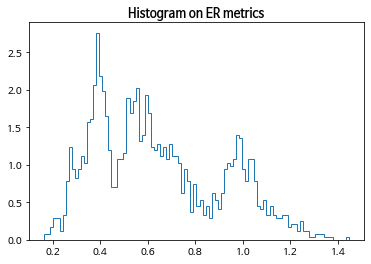

In [120]:
# Plotting(1) apply ER metrics 

plt.hist(a[a!=0], bins=100, density=True, histtype='step')
plt.title('Histogram on ER metrics', fontsize=12, fontweight='bold')
plt.savefig(f'Histogram_on_ER_metrics.png', dpi=300)
plt.show()

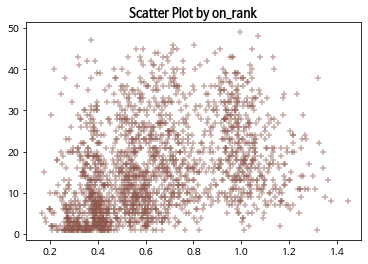

In [113]:
# Plotting(2)

rank = df[a!=0]
rank_df = rank['on_rank']

plt.scatter(a[a!=0], rank_df, c='#8c564b', marker='+', alpha=0.5)
plt.xlim((0.1,1.5))
plt.title('Scatter Plot by on_rank', fontsize=12, fontweight='bold')
plt.savefig(f'Scatter_Plot_by_on_rank.png', dpi=300)
plt.show()

In [121]:
np.corrcoef(a[a!=0],rank_df)

array([[1.        , 0.35093178],
       [0.35093178, 1.        ]])